# Hand-crafted features for GTZAN

> The goal of this notebook is to create several audio features descriptors for the GTZAN dataset, as proposed for many year as input for machine learning algorithms. We are going to use timbral texture based features and tempo based features for this. The main goal is to produce this features, classify and then compare with our proposed deep learning approach, using CNNs on the raw audio.

In [1]:
import os
import librosa
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
from scipy.stats import skew

In [2]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import lightgbm as lgbm

In [3]:
# Set the seed
np.random.seed(42)

In [4]:
gtzan_dir = '../data/genres/'

In [5]:
# Parameters
song_samples = 22050*30
genres = {'metal': 0, 'disco': 1, 'classical': 2, 'hiphop': 3, 'jazz': 4, 
          'country': 5, 'pop': 6, 'blues': 7, 'reggae': 8, 'rock': 9}

In [6]:
def get_features(y, sr, n_fft = 1024, hop_length = 512):
    # Features to concatenate in the final dictionary
    features = {'centroid': None, 'roloff': None, 'flux': None, 'rmse': None, 'zcr': None}
    
    # Using librosa to calculate the features
    features['centroid'] = librosa.feature.spectral_centroid(y, sr=sr, n_fft=n_fft, hop_length=hop_length).ravel()
    features['roloff'] = librosa.feature.spectral_rolloff(y, sr=sr, n_fft=n_fft, hop_length=hop_length).ravel()
    features['zcr'] = librosa.feature.zero_crossing_rate(y, frame_length=n_fft, hop_length=hop_length).ravel()
    features['rmse'] = librosa.feature.rms(y, frame_length=n_fft, hop_length=hop_length).ravel()
    features['flux'] = librosa.onset.onset_strength(y=y, sr=sr).ravel()
    
    # MFCC treatment
    mfcc = librosa.feature.mfcc(y, n_fft = n_fft, hop_length = hop_length, n_mfcc=13)
    for idx, v_mfcc in enumerate(mfcc):
        features['mfcc_{}'.format(idx)] = v_mfcc.ravel()
        
    # Get statistics from the vectors
    def get_moments(descriptors):
        result = {}
        for k, v in descriptors.items():
            result['{}_mean'.format(k)] = np.mean(v)
            result['{}_std'.format(k)] = np.std(v)
            result['{}_kurtosis'.format(k)] = kurtosis(v)
            result['{}_skew'.format(k)] = skew(v)
        return result
    
    dict_agg_features = get_moments(features)
    dict_agg_features['tempo'] = librosa.beat.tempo(y, sr=sr)[0]
    
    return dict_agg_features

In [7]:
def read_process_songs(src_dir, debug = True):    
    # Empty array of dicts with the processed features from all files
    arr_features = []

    # Read files from the folders
    for x,_ in genres.items():
        folder = src_dir + x
        
        for root, subdirs, files in os.walk(folder):
            for file in files:
                # Read the audio file
                file_name = folder + "/" + file
                signal, sr = librosa.load(file_name)
                
                # Debug process
                if debug:
                    print("Reading file: {}".format(file_name))
                
                # Append the result to the data structure
                features = get_features(signal, sr)
                features['genre'] = genres[x]
                arr_features.append(features)
    return arr_features

In [8]:
%%time

# Get list of dicts with features and convert to dataframe
features = read_process_songs(gtzan_dir, debug=False)

Wall time: 2min 43s


In [9]:
df_features = pd.DataFrame(features)

In [10]:
df_features.shape

(1000, 74)

In [11]:
df_features.head()

,centroid_mean,centroid_std,centroid_kurtosis,centroid_skew,roloff_mean,roloff_std,roloff_kurtosis,roloff_skew,flux_mean,flux_std,...,mfcc_11_mean,mfcc_11_std,mfcc_11_kurtosis,mfcc_11_skew,mfcc_12_mean,mfcc_12_std,mfcc_12_kurtosis,mfcc_12_skew,tempo,genre
0,3176.995746,550.485825,1.277930,0.851571,6235.702536,1316.782580,-0.180793,0.740059,1.131944,0.640262,...,10.570468,8.282725,-0.381803,-0.087361,-4.103275,8.186303,0.171622,-0.170111,95.703125,0
1,2850.163030,450.508356,7.136744,1.872261,5926.993343,852.511470,3.561296,1.291193,1.104693,0.689680,...,11.399026,7.171574,-0.122149,0.049450,-10.894270,7.584343,0.193536,0.236081,151.999081,0
2,2147.049597,394.428946,3.603367,1.476032,4376.752601,842.133273,1.952754,1.401493,1.156895,0.801254,...,9.597200,7.135582,-0.228953,-0.074895,-14.248710,7.786307,0.161245,-0.130394,112.347147,0
3,2700.584556,411.301524,-0.256259,0.124371,5178.110839,679.032203,-0.233782,0.240711,1.165081,0.663197,...,15.695696,6.359774,0.157389,-0.127252,-13.005329,6.983782,0.370824,0.127291,99.384014,0
4,3357.385889,548.509155,1.316912,0.691435,6810.304320,964.532861,-0.009224,0.129295,1.263426,0.848756,...,11.683862,7.427122,-0.134480,0.061888,-3.429460,7.443413,0.033728,0.119981,135.999178,0


In [12]:
df_features.to_csv('../data/gtzan_features.csv', index=False)

In [13]:
X = df_features.drop(['genre'], axis=1).values
y = df_features['genre'].values

## Visualization

> Linear (and nonlinear) dimensionality reduction of the GTZAN features for visualization purposes

In [14]:
# Standartize the dataset
scale = StandardScaler()
x_scaled = scale.fit_transform(X)

In [15]:
# Use PCA only for visualization
pca = PCA(n_components=35, whiten=True)
x_pca = pca.fit_transform(x_scaled)
print("cumulative explained variance ratio = {:.4f}".format(np.sum(pca.explained_variance_ratio_)))

cumulative explained variance ratio = 0.9074


In [16]:
# Use LDA only for visualization
lda = LDA()
x_lda = lda.fit_transform(x_scaled, y)

In [17]:
# Using tsne
tsne = TSNE(n_components=2, verbose=1, learning_rate=250)
x_tsne = tsne.fit_transform(x_scaled)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.002s...
[t-SNE] Computed neighbors for 1000 samples in 0.127s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 2.529069
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.170174
[t-SNE] KL divergence after 1000 iterations: 1.223758


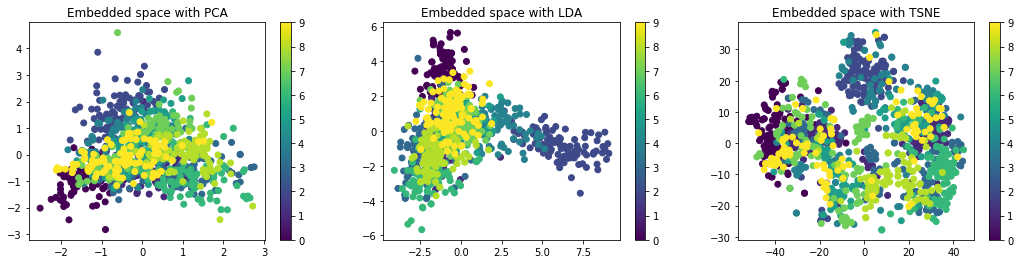

In [18]:
plt.figure(figsize=(18, 4))
plt.subplot(131)
plt.scatter(x_pca[:,0], x_pca[:,1], c=y)
plt.colorbar()
plt.title("Embedded space with PCA")

plt.subplot(132)
plt.scatter(x_lda[:,0], x_lda[:,1], c=y)
plt.colorbar()
plt.title("Embedded space with LDA")

plt.subplot(133)
plt.scatter(x_tsne[:,0], x_tsne[:,1], c=y)
plt.colorbar()
plt.title("Embedded space with TSNE")
plt.show()

## Classical Machine Learning

In [19]:
# Helper to plot confusion matrix -- from Scikit-learn website
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

### Decision Tree

In [20]:
params = {
    "cls__criterion": ["gini", "entropy"],
    "cls__splitter": ["best", "random"],
}

pipe_cart = Pipeline([
    ('cls', DecisionTreeClassifier())
])

grid_cart = GridSearchCV(pipe_cart, params, scoring='accuracy', n_jobs=6, cv=5)
grid_cart.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('cls',
                                        DecisionTreeClassifier(class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features=None,
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_split=None,
                                                               min_samples_leaf=1,
                                                               min_samples_split=2,
                                                               min_weight_fraction_leaf=0.0,
          

In [21]:
print("best score (accuracy) = {:.4f}".format(grid_cart.best_score_))

best score (accuracy) = 0.4200


### Logistic Regression

In [22]:
params = {
    "cls__penalty": ["l1", "l2"],
    "cls__C": [0.5, 1, 2, 5],
}

pipe_lr = Pipeline([
    ('scale', StandardScaler()),
    ('cls', LogisticRegression())
])

grid_lr = GridSearchCV(pipe_lr, params, scoring='accuracy', n_jobs=6, cv=5)
grid_lr.fit(X, y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('cls',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                           multi_class='warn'

In [23]:
print("best score (accuracy) = {:.4f}".format(grid_lr.best_score_))

best score (accuracy) = 0.6280


### Random Forest

In [24]:
params = {
    "cls__n_estimators": [100, 250, 500, 1000],
    "cls__criterion": ["gini", "entropy"],
    "cls__max_depth": [5, 7, None]
}

pipe_rf = Pipeline([
    ('cls', RandomForestClassifier())
])

grid_rf = GridSearchCV(pipe_rf, params, scoring='accuracy', n_jobs=6, cv=5)
grid_rf.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('cls',
                                        RandomForestClassifier(bootstrap=True,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_split=None,
                                                               min_samples_leaf=1,
                                                               min_samples_split=2,
                      

In [25]:
print("best score (accuracy) = {:.4f}".format(grid_rf.best_score_))

best score (accuracy) = 0.5860


### SVM

In [26]:
params = {
    "cls__C": [0.5, 1, 2, 5],
    "cls__kernel": ['rbf', 'linear', 'sigmoid'],
}

pipe_svm = Pipeline([
    ('scale', StandardScaler()),
    ('cls', SVC())
])

grid_svm = GridSearchCV(pipe_svm, params, scoring='accuracy', n_jobs=6, cv=5)
grid_svm.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('cls',
                                        SVC(C=1.0, cache_size=200,
                                            class_weight=None, coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='auto_deprecated',
                                            kernel='rbf', max_iter=-1,
                                            probability=False,
                                            random_state=None, shrinking=True,
                                            tol=0.001, verbose=False))],
                 

In [27]:
print("best score (accuracy) = {:.4f}".format(grid_svm.best_score_))

best score (accuracy) = 0.6530


## Results and save the model

In [28]:
from sklearn.externals import joblib

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [29]:
joblib.dump(grid_svm, "../models/pipe_svm.joblib")

['../models/pipe_svm.joblib']